# EDA+Baseline Model
https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
#plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [171]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
test.shape

(625134, 9)

## Convert to appropriate datatype
픽업 시간과 하차 시간을 date-time 오브젝트로 변환합니다.

In [172]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## 결측값 확인

In [173]:
train[pd.isnull(train)].sum()

id                    0  
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0  
trip_duration         0.0
dtype: object

결측값은 없습니다.

## 데이터셋의 기간 확인

In [174]:
print('Min pickup time:', min(train['pickup_datetime']))
print('Max pickup time:', max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


데이터는 1월부터 6월 말까지 총 6개월로 되어있습니다.

## 새로운 일, 월, 시간 정보 추가 

In [175]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])


## 위도, 경도 3자리수 반올림

In [176]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x:round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x:round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x:round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x:round(x, 3))
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


## 위도, 경도에 기반한 여행의 km 계산
Haversine Distance를 사용합니다.

In [177]:
def calculateDistance(row):
    R = 6373.0 # 지구 반지름 km 대략치
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

In [178]:
train['trip_distance'] = train.apply(lambda row: calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [179]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


## 탐색적 분석

Text(0.5, 0, 'Trip Duration (in hour)')

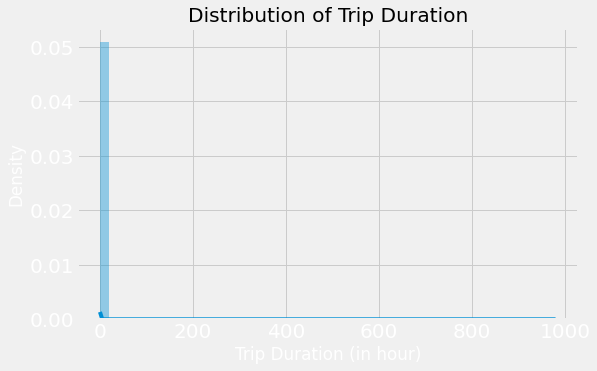

In [180]:
plt.figure(figsize=(8, 5))
sns.distplot(train['trip_duration_in_hour']).set_title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (in hour)')

24시간이 넘어가는 여행도 있습니다. 이에 대해 자세히 살펴보겠습니다.

In [181]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,2016-01-05,5,0,Tuesday,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2016-02-13,13,22,Saturday,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,2016-01-05,5,6,Tuesday,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2016-02-13,13,22,Saturday,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


4개의 기록이 매우 긴 여행을 하고 있습니다. 그러나 거리를 보면 20km 이내로 매우 짧습니다. 이들은 이상치 입니다. 하지만 이 여행이 시작되거나 끝나는 특별한 장소가 있는지 살펴봐야합니다. 여행 지속시간도 왜곡되어 있으므로 로그 변환을 살펴보겠습니다.

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

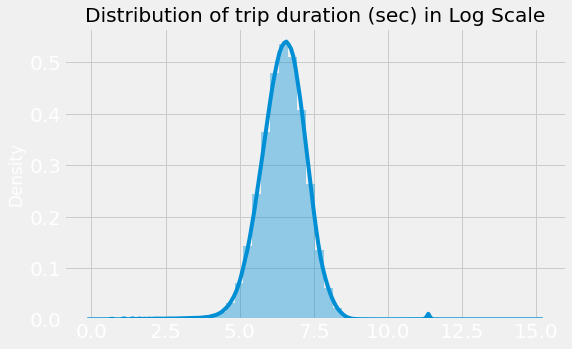

In [182]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log(train['trip_duration'].values)).set_title('Distribution of Trip Duration')
plt.title('Distribution of trip duration (sec) in Log Scale')

여행 지속 시간의 로그 변환은 정규분포를 따릅니다. 대부분의 여행은 54초(exp(4))dptj 2980초(exp(8)) 사이입니다. 이것은 대부분의 여행이 1시간 이내임을 나타냅니다. 하지만 1분도 안되는 여행이 있고, 100시간 동안 지속되는 여행들이 있는데 택시들이 뉴욕안에 있기 때문에 이상합니다.

### 픽업 및 하차가 발생하는 공통 위치 히트맵

In [183]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [184]:
pickup_map = folium.Map(location = [40.730610, -73.935242], zoom_start=10)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, np.array(pickup.Num_Trips.values).astype('float64'))),
                  min_opacity=0.4,
                  radius=5,
                  blur=6,
                  max_zoom=1
                 )
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

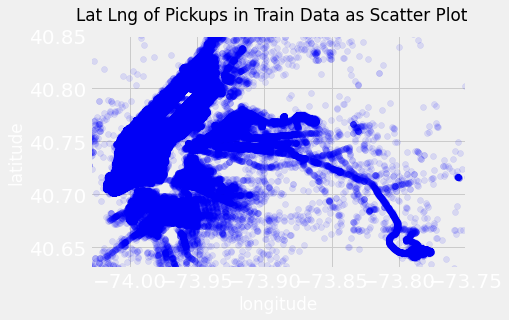

In [185]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

이 그래프는 JFK 근처의 픽업 밀도가 높다는 것을 분명히 보여줍니다.

In [186]:
drop = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [187]:
drop_map = folium.Map(location = [40.730610, -73.935242], zoom_start=10)

hm_wide = HeatMap(list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, np.array(drop.Num_Trips.values).astype('float64'))),
                  min_opacity=0.4,
                  radius=5,
                  blur=6,
                  max_zoom=1
                 )
drop_map.add_child(hm_wide)

drop_map

픽업 히트맵과 유사합니다.

## 여행 지속시간의 히트맵(픽업이 한 지점에서 시작된 경우)

In [188]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'Avg_Trip_duration'})

In [189]:
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, np.array(pickup.Avg_Trip_duration.values).astype('float64'))),
                  min_opacity = 0.4,
                  radius=7,
                  blur=6,
                  max_zoom=1)

pickup_map.add_child(hm_wide)
pickup_map

평균 주행 지속 시간은 JFK에서 출발한 경우 더 높습니다. 확대해보면 맨하탄 이후 JFK의 픽업 차량이 더 오래 걸리는 것을 알 수 있습니다.

## 탑승/ 하차 시간 분포

Text(0.5, 1.0, 'Pickup Hours Distribution')

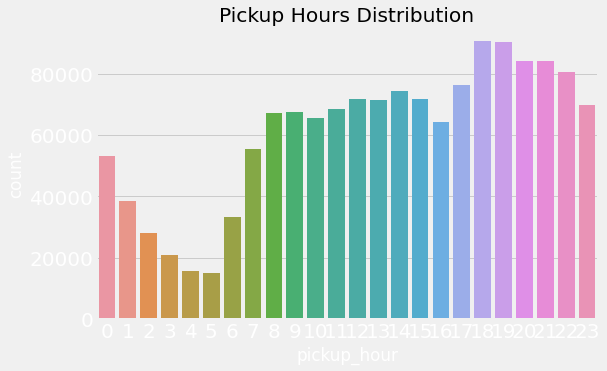

In [190]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')

이른 아침에 가장 낮습니다. 대부분의 픽업은 오후 6-8시 사이에 가장 높습니다.

Text(0.5, 1.0, 'Dropoff Hours Distribution')

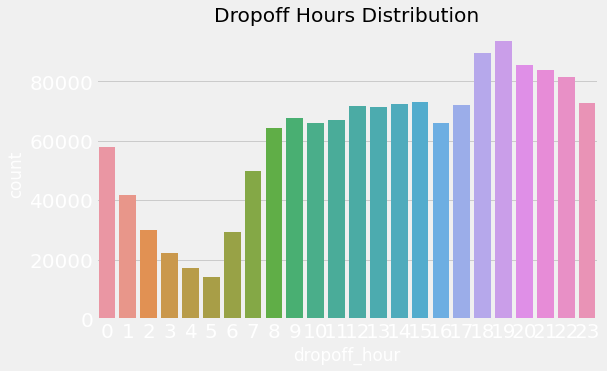

In [191]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['dropoff_hour']).set_title('Dropoff Hours Distribution')

픽업 시간대와 유사합니다.

## 전체 기간의 픽업 빈도

Text(0.5, 1.0, 'Distribution of Pickups over time')

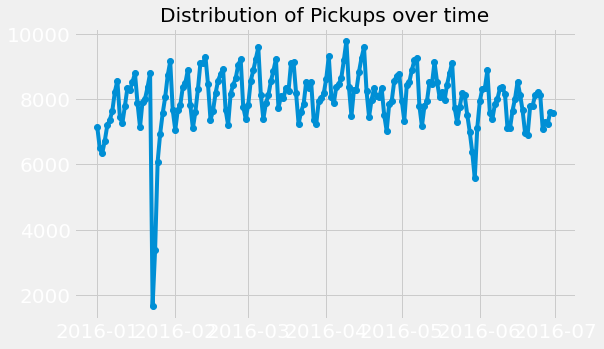

In [192]:
plt.figure(figsize=(8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')

plt.title('Distribution of Pickups over time')

2016년 1월에 급감하는 것을 알 수 있습니다.

## 여행 거리 분포

Text(0.5, 0, 'Trip Distance (log)')

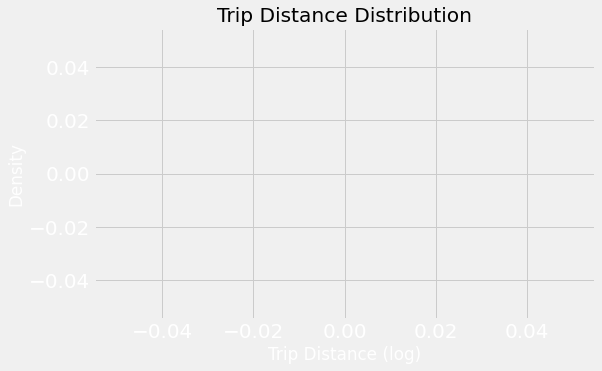

In [193]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=np.log(train['trip_distance'].values)).set_title('Trip Distance Distribution')
plt.xlabel('Trip Distance (log)')

## 여행 기간 vs 여행 거리

Text(0, 0.5, 'Trip Duration (log)')

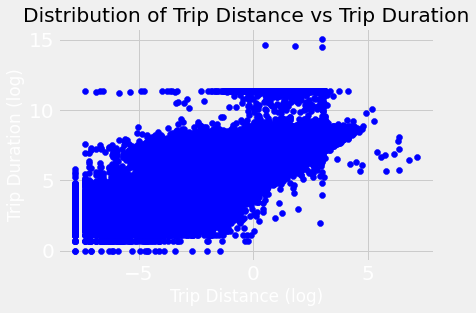

In [194]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
            color='blue', label='train')
plt.title('Distribution of Trip Distance vs Trip Duration')
plt.xlabel('Trip Distance (log)')
plt.ylabel('Trip Duration (log)')

## 시간에 따른 여행 기간의 변화 

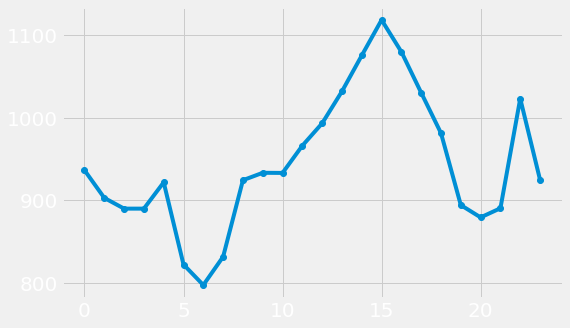

In [195]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

여행 기간이 10-15시에 증가합니다.

## 요일에 따른 픽업 분포

<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

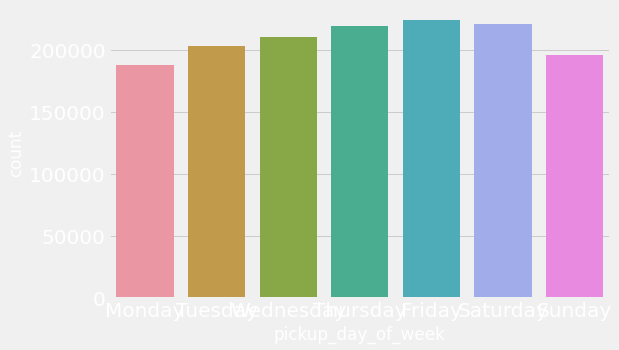

In [196]:
plt.figure(figsize=(8, 5))
sns.countplot(train['pickup_day_of_week'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

월요일이 제일 낮습니다. 화요일 부터 금요일까지 증가합니다.

## 요일별 평균 여행 기간

In [197]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

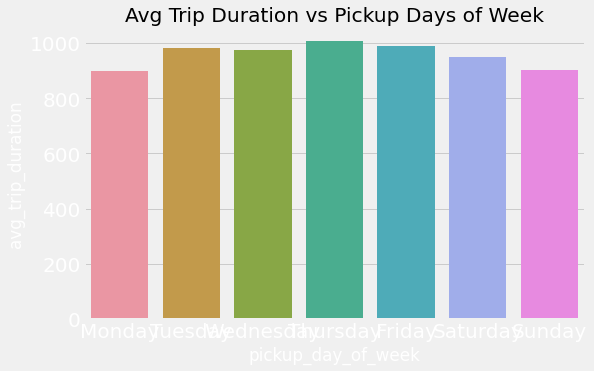

In [198]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday' , 'Sunday']).set_title('Avg Trip Duration vs Pickup Days of Week')

가장 평균 여행기간이 높은 요일은 목요일 입니다.

## 계산된 필드 베어링 생성
베어링은 이동 방향을 측정합니다. 공식은 다음과 같습니다.

 θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
 
 λ는 경도입니다.


In [199]:
def calculateBearing(lat1, lng1, lat2, lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2-lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [200]:
train['bearing'] = train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)

## 베어링 분포

<AxesSubplot:xlabel='bearing', ylabel='Density'>

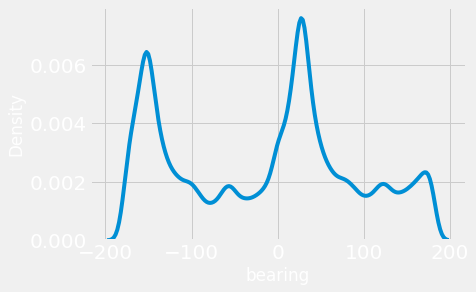

In [201]:
sns.kdeplot(train['bearing'])

## 베어링 vs 여행 기간

Text(0, 0.5, 'Trip Duration (log scale)')

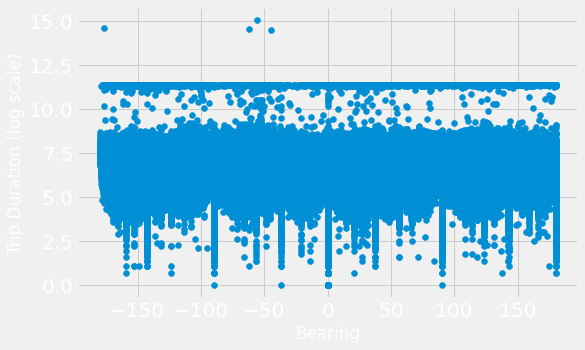

In [202]:
plt.figure(figsize=(8, 5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel('Bearing')
plt.ylabel('Trip Duration (log scale)')

여행 기간의 이상치가 베어링의 -50 근처에 있습니다.

## Store and FWD Flag 분포

In [203]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

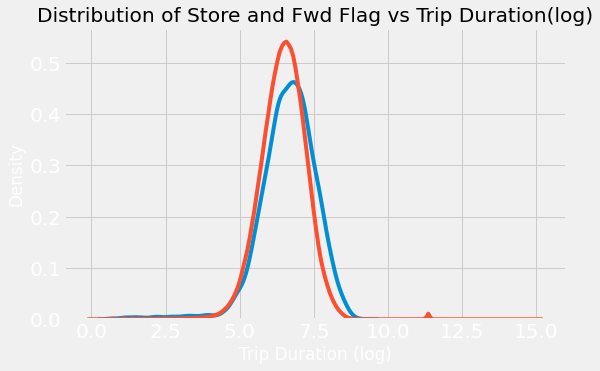

In [204]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y', 'trip_duration'].values), label='Store and Fwd=Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N', 'trip_duration'].values), label='Store and Fwd=No')

plt.title('Distribution of Store and Fwd Flag vs Trip Duration(log)')
plt.xlabel('Trip Duration (log)')
plt.ylabel('Density')

## 위치를 클러스터로 그룹화
이것은 이웃을 만드는 데 도움이 될 것입니다. 그리고 어떤 동네에서 픽업하는 것이 더 긴 여행 기간을 가질 수 있습니다.

(-74.03, -73.75)

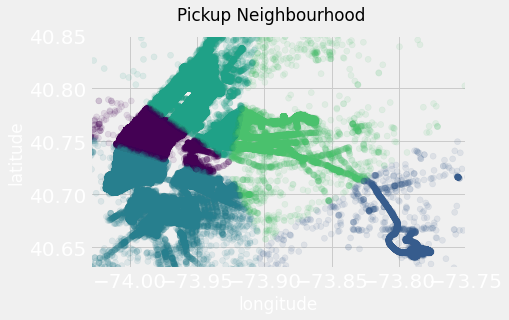

In [205]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

## 이웃별 픽업수

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

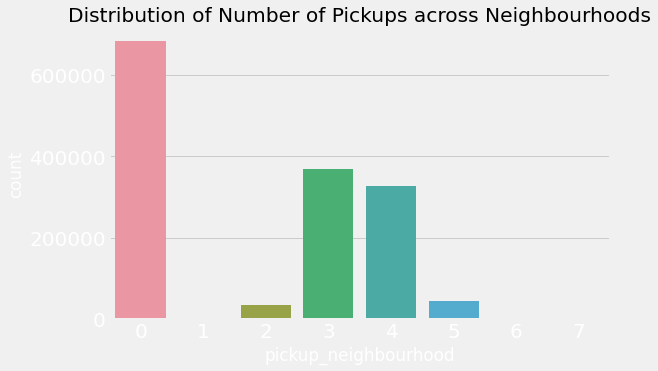

In [206]:
plt.figure(figsize=(8, 5))
sns.countplot(train['pickup_neighbourhood']).set_title('Distribution of Number of Pickups across Neighbourhoods')

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

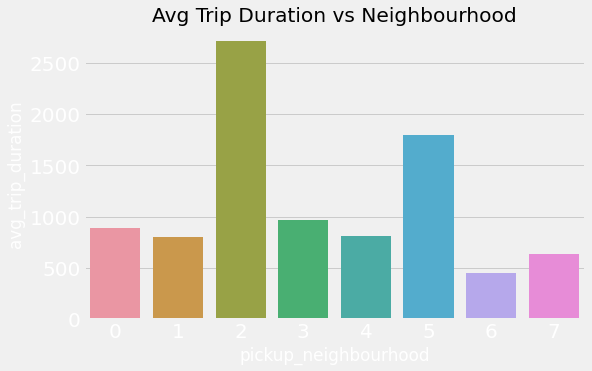

In [207]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood', y='avg_trip_duration', data=avg_duration_neighbourhood).set_title('Avg Trip Duration vs Neighbourhood')

2번 이웃이 가장 평균 여행 기간이 긴 반면, 0번 이웃의 픽업 수가 지배적입니다.

## 평균 속도 분포

Text(0.5, 1.0, 'Distribution of Average Speed (kph)')

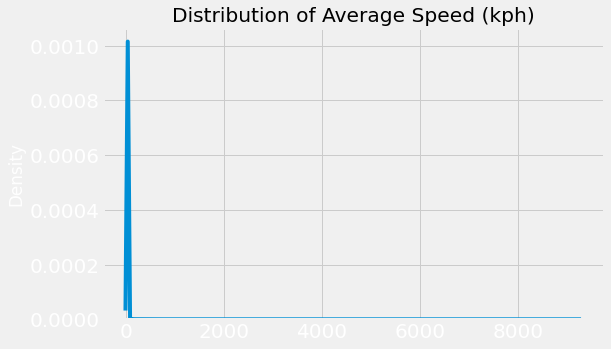

In [208]:
train['avg_speed_kph'] = train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8, 5))
sns.kdeplot(train['avg_speed_kph'].values).set_title('Distribution of Average Speed (kph)')

In [209]:
print('평균속도:', np.mean(train['avg_speed_kph']), 'kph')

평균속도: 14.427736738459107 kph


## 요일별 평균 속도 - 교통량지표

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

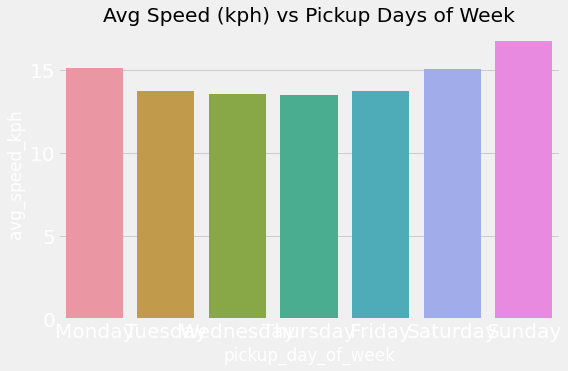

In [210]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data=avg_speed_per_day, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title('Avg Speed (kph) vs Pickup Days of Week')

월요일과 일요일에 평균 속도가 높습니다.

## 테스트 데이터 피쳐 엔지니어링

In [211]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3'] = test['pickup_latitude'].apply(lambda x:round(x, 3))
test['pickup_longitude_round3'] = test['pickup_longitude'].apply(lambda x:round(x, 3))
test['dropoff_latitude_round3'] = test['dropoff_latitude'].apply(lambda x:round(x, 3))
test['dropoff_longitude_round3'] = test['dropoff_longitude'].apply(lambda x:round(x, 3))
test['trip_distance'] = test.apply(lambda row:calculateDistance(row), axis=1)
test['bearing'] = test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

## 모델 구축
훈련 데이터에서 'dropoff datetime 피쳐'를 제거해야 합니다. 또한 lat lng는 소수점 3자리까지만 반올림해둡니다.

In [212]:
drop_cols = ['avg_speed_kph', 'trip_duration_in_hour', 'dropoff_date', 'dropoff_day', 'dropoff_hour', 'dropoff_day_of_week', 'dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
training = train.drop(drop_cols, axis=1)
testing = test.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

trip_duration을 예측합니다, 로그 스케일로 변환후 예측합니다.

In [213]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'], axis=1, inplace=True)

In [214]:
print('Training Data Shape', training.shape)
print('Testing Data Shape', testing.shape)

Training Data Shape (1458644, 18)
Testing Data Shape (625134, 17)


요일에 대해 레이블 인코딩을 합니다.

In [215]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [216]:
training['pickup_day_of_week']=training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week']=testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [217]:
training.to_csv('input_training.csv', index=False)
testing.to_csv('input_testing.csv', index=False)
del training
del testing
del train
del test

In [222]:
def LabelEncoding(train_df, test_df, max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col] = le.transform(train_df[col])
                test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]

def readInputAndEncode(input_path, train_file, test_file, target_column):
    training = pd.read_csv(input_path + train_file)
    testing = pd.read_csv(input_path + test_file)
    
    training, testing = LabelEncoding(training, testing)
    
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    col_in_train_not_test = set(train_cols) - set(test_cols)
    for col in col_in_train_not_test:
        if col != target_column:
            testing[col] = 0
    col_in_test_not_train = set(test_cols) - set(train_cols)
    for col in col_in_test_not_train:
        training[col] = 0
    print('Training Data Shape after Processing', training.shape)
    print('Testing Data Shape after Processing', testing.shape)
    return [training, testing]

In [223]:
train, test = readInputAndEncode("", 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date'], axis=1, inplace=True)
test.drop(['pickup_date'], axis=1, inplace=True)
train.drop(['pickup_datetime'], axis=1, inplace=True)
test.drop(['pickup_datetime'], axis=1, inplace=True)
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

Training Data Shape after Processing (1458644, 18)
Testing Data Shape after Processing (625134, 17)


In [226]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy='median', split=0.25, imputation=True):
    labels = np.array(train[target])
    training = train.drop(target, axis=1)
    training = np.array(training)
    testing = np.array(test)
    if imputation == True:
        imputer = SimpleImputer(strategy = imputing_strategy, missing_values=np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state=42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [227]:
train_features, validation_features, train_labels, validation_labels, testing=GetFeaturesAndSplit(train, test, 'log_trip_duration', imputation=False)

## 선형 회귀 적용

In [228]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [229]:
valid_pred = lm.predict(validation_features )

In [230]:
rmse = mean_squared_error(validation_labels, valid_pred)
print('Root Mean Squared Error for Linear Regression(log)', rmse)

Root Mean Squared Error for Linear Regression(log) 0.40302927200813593


In [231]:
test_pred = lm.predict(testing)
submit=pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('submission_linear_regression_baseline.csv', index=False)
del submit

## RandomForest Regressor 적용

In [232]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [233]:
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [234]:
valid_pred_rf = rf.predict(validation_features)
rmse = mean_squared_error(validation_labels, valid_pred_rf)
print('Root Mean Squared Error for Linear Regression(log)', rmse)

Root Mean Squared Error for Linear Regression(log) 0.16585442479167928


In [235]:
test_pred = rf.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('submission_random_forest_baseline.csv', index=False)

# 